## Statistical Learning and Deep Learning HW4

Load dataset.

In [1]:
# load packages
import pickle
from sklearn import preprocessing
%matplotlib inline

# load data
with open('msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if doscaling == 1:
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    # standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


# validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print()
print("Y_train shape = ", Y_train.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print()
print("X_test shape = ", X_test.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)

Y_train shape =  (463715,)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)

X_test shape =  (51630, 90)
Y_test shape =  (51630,)


### Q1. Oridinary Least Square (OLS)

In [2]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

ols = sm.OLS(Y_train, X_train, hasconst=True)
ols_result = ols.fit()

In [3]:
print(f'The first 5 parameters: {ols_result.params[:5]}')

The first 5 parameters: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


In [4]:
# predict
Y_predict = ols_result.predict(X_test)
print(f'The predicted Y is {Y_predict}')

The predicted Y is [-5.81070695  0.03250657  5.13960445 ... -1.39829429 -0.26047668
  0.05193056]


In [5]:
# RMSE
print(f'RMSE = {mean_squared_error(Y_test, Y_predict, squared=False)}')

RMSE = 9.510160684544402


### Q2. MLP with Four Hidden Layers

In [32]:
import numpy as np
import torch
from torch.utils import data
import os
from sklearn.metrics import mean_squared_error

print('torch version:', torch.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')
print(torch.cuda.current_device())

torch version: 1.7.1rc2
using cuda
0


In [33]:
# define dataset
class Dataset(data.Dataset):
    
  def __init__(self, Xnp, Ynp):
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
        
  def __len__(self):
        return self.nobs
    
  def __getitem__(self, index):     
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

In [34]:
# create dataloader
subtrain_set = Dataset(X_subtrain, Y_subtrain)    
valid_set = Dataset(X_valid, Y_valid)
test_set = Dataset(X_test, Y_test)
print('subtrain length', len(subtrain_set))
print('valid length', len(valid_set))
print('test length', len(test_set))

batch_size = 1000
subtrain_loader = data.DataLoader(subtrain_set, batch_size=batch_size)
valid_loader = data.DataLoader(valid_set, batch_size=batch_size)
test_loader = data.DataLoader(test_set, batch_size=batch_size)

subtrain length 417344
valid length 46371
test length 51630


In [35]:
# train

def RMSE(model, data_loader):
    n_obs = 0
    sse = 0
    with torch.no_grad():
        for _batch, (_inputs, _targets) in enumerate(data_loader):
            _targets = _targets.reshape((-1, 1))
            _inputs, _targets = _inputs.to(device), _targets.to(device)
            _outputs = model(_inputs)
            n_obs += _targets.shape[0]
            sse += (_targets - _outputs).pow(2).sum(0)
    return np.sqrt(sse.cpu().numpy()[0] / n_obs)

    
def train(model, optim, loss_f, max_epoch, max_step, valid_interval, weight_path, train_rmse):
    
    step_count = 0
    best_step_count = 0
    best_valid_rmse = np.inf
    all_train_rmse = []
    all_valid_rmse = []
    all_step = []

    for epoch in range(1, max_epoch+1):
        for batch, (inputs, targets) in enumerate(subtrain_loader):

            targets = targets.reshape((-1, 1))
            inputs, targets = inputs.to(device), targets.to(device)
            model.to(device)
            model.train()
            optim.zero_grad()
            outputs = model(inputs)
            loss = loss_f(outputs, targets)
            loss.backward()
            optim.step()
            step_count += 1

            # check train/validation RMSE
            if (step_count % valid_interval == 0):

                # subtrain, validation RMSE
                if train_rmse:
                    train_rmse = RMSE(model, subtrain_loader)
                    all_train_rmse.append(train_rmse)
                valid_rmse = RMSE(model, valid_loader)
                all_valid_rmse.append(valid_rmse)
                all_step.append(step_count)

                # update weight
                if valid_rmse < best_valid_rmse:
                    best_step_count = step_count
                    best_valid_rmse = valid_rmse
                    torch.save(model, weight_path)

                # early stopping
                elif (step_count - best_step_count >= max_step):
                    print(f'early stopping, step {step_count}, validation RMSE = {valid_rmse}')
                    return all_step, all_train_rmse, all_valid_rmse
                
        print(f'Epoch {epoch}, Step {step_count}: Loss = {loss.item()}, best_valid_rmse = {best_valid_rmse}')
    return all_step, all_train_rmse, all_valid_rmse

In [36]:
# create MLP model
d_hidden = 45
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP45_weight'

# optimizer
lr = 0.00001
momentum = 0
weight_decay = 0
sgd_optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

# loss
l2_loss = torch.nn.MSELoss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        


Epoch 1, Step 418: Loss = 34781.6796875, best_valid_rmse = 8.860106849822154
Epoch 2, Step 836: Loss = 34487.375, best_valid_rmse = 8.702837418786082
Epoch 3, Step 1254: Loss = 33778.6796875, best_valid_rmse = 8.702837418786082
Epoch 4, Step 1672: Loss = 33408.859375, best_valid_rmse = 8.626972306832297
Epoch 5, Step 2090: Loss = 32994.0, best_valid_rmse = 8.608287438525126
Epoch 6, Step 2508: Loss = 32655.318359375, best_valid_rmse = 8.608287438525126
Epoch 7, Step 2926: Loss = 32260.447265625, best_valid_rmse = 8.608287438525126
Epoch 8, Step 3344: Loss = 32052.34375, best_valid_rmse = 8.608287438525126
Epoch 9, Step 3762: Loss = 31624.125, best_valid_rmse = 8.595136536786487
Epoch 10, Step 4180: Loss = 31520.8671875, best_valid_rmse = 8.595136536786487
Epoch 11, Step 4598: Loss = 31148.158203125, best_valid_rmse = 8.595136536786487
Epoch 12, Step 5016: Loss = 30616.66796875, best_valid_rmse = 8.58854097998283
Epoch 13, Step 5434: Loss = 30132.236328125, best_valid_rmse = 8.588540979

Text(0.5, 1.0, 'H=45, Training & Validation RMSE')

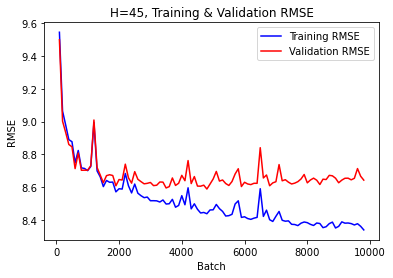

In [37]:
import matplotlib.pyplot as plt

# plot subtrain / validation RMSE
plt.plot(all_step, all_train_rmse, c='b', label='Training RMSE')
plt.plot(all_step, all_valid_rmse, c='r', label='Validation RMSE')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('H=45, Training & Validation RMSE')

From the figure above, we can see that both training RMSE and validation RMSE reduce but fluctuate through the training process. While the two curves are quite close in the beginning, training RMSE turns out to be lower than training RMSE.

In [38]:
# test RMSE
saved_mlp = torch.load(weight_path)
test_rmse = RMSE(saved_mlp, test_loader)
print(f'Test RMSE = {test_rmse}')

Test RMSE = 8.81752794992918


### Q3. H = 90, 180

In [39]:
for d_hidden in [90, 180]:
    
    d_input = subtrain_set.Xnp.shape[1]
    d_output = 1

    mlp = torch.nn.Sequential(
        torch.nn.Linear(d_input, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(d_hidden, d_output)
    )
    
    # optimizer
    lr = 0.00001
    momentum = 0
    weight_decay = 0
    sgd_optimizer = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # loss
    l2_loss = torch.nn.MSELoss(reduction='sum')
    
    mlp = mlp.float()
    mlp.to(device)
    weight_path = f'./MLP{d_hidden}_weight'
    all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)
    saved_mlp = torch.load(weight_path)
    test_rmse = RMSE(saved_mlp, test_loader)
    print(f'H = {d_hidden}, Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 34292.0390625, best_valid_rmse = 8.85406946891178
Epoch 2, Step 836: Loss = 34249.2734375, best_valid_rmse = 8.661730250864041
Epoch 3, Step 1254: Loss = 33584.23828125, best_valid_rmse = 8.649656074930018
Epoch 4, Step 1672: Loss = 32857.33984375, best_valid_rmse = 8.564246667189845
Epoch 5, Step 2090: Loss = 33378.23828125, best_valid_rmse = 8.55240647979954
Epoch 6, Step 2508: Loss = 33139.3671875, best_valid_rmse = 8.55240647979954
Epoch 7, Step 2926: Loss = 33039.8984375, best_valid_rmse = 8.55240647979954
Epoch 8, Step 3344: Loss = 32810.48828125, best_valid_rmse = 8.546891047297116
Epoch 9, Step 3762: Loss = 32451.1171875, best_valid_rmse = 8.545656500458556
Epoch 10, Step 4180: Loss = 31947.486328125, best_valid_rmse = 8.545656500458556
Epoch 11, Step 4598: Loss = 32043.06640625, best_valid_rmse = 8.545656500458556
Epoch 12, Step 5016: Loss = 32329.486328125, best_valid_rmse = 8.536736220813307
Epoch 13, Step 5434: Loss = 31705.66796875, best_valid_rms

(hidden dimension = 45: test RMSE = 8.818)  
**hidden dimension = 90: test RMSE = 8.861**  
**hidden dimension = 180: test RMSE = 8.872**

With test RMSE shown above, we suggest that providing 45 hidden nodes in the linear hidden layers performs the best. Larger number of hidden nodes may lead to overfitting.

### Q4 MLP with Weight Decay

In [40]:
for d_hidden in [45, 90, 180]:
    for weight_decay in [0.1, 0.2, 0.4]:
    
        d_input = subtrain_set.Xnp.shape[1]
        d_output = 1

        mlp = torch.nn.Sequential(
            torch.nn.Linear(d_input, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(d_hidden, d_output)
        )

        mlp = mlp.float()
        mlp.to(device)

        # optimizer
        lr = 0.00001
        momentum = 0
        sgd_optimizer_wd = torch.optim.SGD(mlp.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

        weight_path = f'./MLP{d_hidden}_{weight_decay*10}_weight'
        all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=sgd_optimizer_wd, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=False)
        saved_mlp = torch.load(weight_path)
        test_rmse = RMSE(saved_mlp, test_loader)
        print(f'H = {d_hidden} Weight decay = {weight_decay}, Test RMSE = {test_rmse}\n')

Epoch 1, Step 418: Loss = 35281.1640625, best_valid_rmse = 8.888397008954936
Epoch 2, Step 836: Loss = 34135.1484375, best_valid_rmse = 8.716717432365973
Epoch 3, Step 1254: Loss = 33117.171875, best_valid_rmse = 8.691299866210302
Epoch 4, Step 1672: Loss = 33125.21875, best_valid_rmse = 8.612813086657857
Epoch 5, Step 2090: Loss = 32945.1796875, best_valid_rmse = 8.60795299215972
Epoch 6, Step 2508: Loss = 32488.421875, best_valid_rmse = 8.60795299215972
Epoch 7, Step 2926: Loss = 32628.716796875, best_valid_rmse = 8.60795299215972
Epoch 8, Step 3344: Loss = 32436.42578125, best_valid_rmse = 8.584916005229564
Epoch 9, Step 3762: Loss = 32297.05078125, best_valid_rmse = 8.584916005229564
Epoch 10, Step 4180: Loss = 32064.0703125, best_valid_rmse = 8.584916005229564
Epoch 11, Step 4598: Loss = 31965.109375, best_valid_rmse = 8.58380689106744
Epoch 12, Step 5016: Loss = 32306.587890625, best_valid_rmse = 8.573213785314081
Epoch 13, Step 5434: Loss = 31907.21875, best_valid_rmse = 8.57321

|    Test RMSE     | H=45  | H=90  | H=180 |
| ---------------- | ----- | ----- | ----- |
| weight_decay=0.1 | 8.838 | 8.830 | 8.801 |
| weight_decay=0.2 | 8.825 | 8.807 | 8.898 |
| weight_decay=0.4 | 8.820 | 8.790 | 8.821 |

From the table above, we can see that **H=90** with **weight_decay=0.4** leads to the lowest testing RMSE.

### Q5. MLP with Dropout

In [41]:
d_hidden = 90
d_input = subtrain_set.Xnp.shape[1]
d_output = 1

mlp = torch.nn.Sequential(
    torch.nn.Linear(d_input, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_hidden),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    
    torch.nn.Linear(d_hidden, d_output)
)
mlp = mlp.float()
mlp.to(device)
weight_path = './MLP90_drop_weight'

# optimizer
lr = 0.001
momentum = 0
weight_decay = 0
adam_optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=weight_decay)

# loss
l2_loss = torch.nn.MSELoss(reduction='sum')

# train
all_step, all_train_rmse, all_valid_rmse = train(model=mlp, optim=adam_optimizer, loss_f=l2_loss, max_epoch=100, max_step=5000, valid_interval=100, weight_path=weight_path, train_rmse=True)        


Epoch 1, Step 418: Loss = 37670.83984375, best_valid_rmse = 9.190845247721088
Epoch 2, Step 836: Loss = 36741.15234375, best_valid_rmse = 9.059547600744455
Epoch 3, Step 1254: Loss = 37460.046875, best_valid_rmse = 9.007087967281201
Epoch 4, Step 1672: Loss = 36279.3515625, best_valid_rmse = 8.958269233047481
Epoch 5, Step 2090: Loss = 35615.046875, best_valid_rmse = 8.931756669273494
Epoch 6, Step 2508: Loss = 32741.505859375, best_valid_rmse = 8.90104650501457
Epoch 7, Step 2926: Loss = 33730.34375, best_valid_rmse = 8.89246242315414
Epoch 8, Step 3344: Loss = 33638.73828125, best_valid_rmse = 8.88887010917197
Epoch 9, Step 3762: Loss = 34697.296875, best_valid_rmse = 8.874893027598748
Epoch 10, Step 4180: Loss = 33732.59375, best_valid_rmse = 8.866916296584753
Epoch 11, Step 4598: Loss = 35133.3984375, best_valid_rmse = 8.866916296584753
Epoch 12, Step 5016: Loss = 35447.93359375, best_valid_rmse = 8.866916296584753
Epoch 13, Step 5434: Loss = 35766.65234375, best_valid_rmse = 8.866

Text(0.5, 1.0, 'H=90 with Drop Out, Training & Validation RMSE')

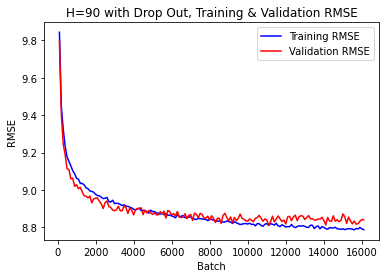

In [42]:
# plot subtrain / validation RMSE
plt.plot(all_step, all_train_rmse, c='b', label='Training RMSE')
plt.plot(all_step, all_valid_rmse, c='r', label='Validation RMSE')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.title('H=90 with Drop Out, Training & Validation RMSE')

From the figure above, we can see that both training RMSE and validation RMSE drop dramastically in the beginning of the training process and converges afterwards. In the first half of the training process, training RMSE is larger than validation RMSE, while in the second half, training RMSE turns out to be smaller than validation RMSE.

In [43]:
# test RMSE
saved_mlp = torch.load(weight_path)
test_rmse = RMSE(saved_mlp, test_loader)
print(f'Test RMSE = {test_rmse}')

Test RMSE = 9.021474047833808
